# Imports

In [1]:
import time
import json
import matplotlib.pyplot as plt
import torch

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image
from PIL import Image

import numpy as np
import matplotlib.patches as patches
from torchvision import transforms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchmetrics.detection.map import MeanAveragePrecision

import pycocotools

In [2]:
# imports from local lib files
import utils
import transforms
import coco_eval
from engine import train_one_epoch, evaluate

In [3]:
# Imports for evaluation from local lib files
from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
from engine import _get_iou_types 

# Functions and initiations

## File paths

In [4]:
output_path = 'output'
img_folder = 'eccv_18_all_images_sm'

cis_test_ann_path = 'eccv_18_annotation_files/cis_test_annotations.json'
cis_val_ann_path = 'eccv_18_annotation_files/cis_val_annotations.json'
train_ann_path = 'eccv_18_annotation_files/train_annotations.json'
trans_test_ann_path = 'eccv_18_annotation_files/trans_test_annotations.json'
trans_val_ann_path = 'eccv_18_annotation_files/trans_val_annotations.json'

## Basic data exploration

In [5]:
cis_test_ann = json.load(open(cis_test_ann_path))
cis_val_ann = json.load(open(cis_val_ann_path))
train_ann = json.load(open(train_ann_path))
trans_test_ann = json.load(open(trans_test_ann_path))
trans_val_ann = json.load(open(trans_val_ann_path))

In [6]:
print('cis test set length:', len(cis_test_ann['images']))
print('cis val set length:', len(cis_val_ann['images']))
print('train set length:', len(train_ann['images']))
print('trans test set length:', len(trans_test_ann['images']))
print('trans val set length:', len(trans_val_ann['images']))

cis test set length: 15827
cis val set length: 3484
train set length: 13553
trans test set length: 23275
trans val set length: 1725


## Utils

In [7]:
# In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

import transforms as T   # from git hub repo

data_transform = {'train': T.RandomHorizontalFlip(0.5)}

In [8]:
# Returns a list with the idx of images with at least one bounding box (img_wbbox) and a 
# list with the number of bbox for each valid image (num_bbox)
def get_img_with_bbox(file_path):
  
    file = json.load(open(file_path))
    img_wbbox = []
    num_bbox = []

    for i in range(len(file['images'])):
        bboxes = [file['annotations'][j]['bbox'] 
                  for j in range(len(file['annotations'])) 
                  if file['annotations'][j]['image_id']==file['images'][i]['id'] 
                  and 'bbox' in file['annotations'][j].keys()]

        if len(bboxes)!=0:
            img_wbbox.append(i)

            num_bbox.append(len(bboxes))

    return img_wbbox, num_bbox

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, label_path, img_dir, valid_img, transform = None):
        self.label_file = json.load(open(label_path))
        self.img_dir = img_dir
        self.transform = transform
        self.valid_img = valid_img

    def __len__(self):
        return len(self.valid_img)

    def __getitem__(self, idx):
        
        idx = self.valid_img[idx] # consider only images with bbox annotations
        img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
        image = read_image(img_path)

        conv = torchvision.transforms.ToTensor()
        # if image.shape[0]==1:
        # some images have only one channel, we convert them to rgb
        image = Image.open(img_path).convert("RGB")
        image = conv(image)

        boxes = [self.label_file['annotations'][j]['bbox'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        
        label = [self.label_file['annotations'][j]['category_id'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

        # transform bbox coords to adjust for resizing
        scale_x = image.shape[2] / self.label_file['images'][idx]['width'] 
        scale_y = image.shape[1] / self.label_file['images'][idx]['height']

        boxes = torch.as_tensor(boxes)
        for i in range(boxes.shape[0]):
            boxes[i][0] = torch.round(boxes[i][0] * scale_x)
            boxes[i][1] = torch.round(boxes[i][1] * scale_y)
            boxes[i][2] = torch.round(boxes[i][2] * scale_x)
            boxes[i][3] = torch.round(boxes[i][3] * scale_y)

            boxes[i][2] = boxes[i][0] + boxes[i][2] # to transform to pytorch bbox format
            boxes[i][3] = boxes[i][1] + boxes[i][3]

        label = torch.as_tensor(label)
        label = torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["image_id"] = image_id
        target['area']=area
        target['iscrowd']=iscrowd

        # TO DO : resize all to same size

        if self.transform:
            # transform image AND target
            image, target = self.transform(image, target)

        return image, target

## Transformation

In [10]:
# import transforms as T
# import torchvision.transforms as TorchTrans
# # In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

# colorTranformations = torch.nn.Sequential(
#                       TorchTrans.RandomInvert(0.6),
#                       TorchTrans.ColorJitter([.2,.3], [0.8,0.9], [.1,0.12])#jitter2 = T.ColorJitter([.2,.3], [0.7,0.9],  hue=.1)
# )

In [11]:
# class CustomImageDataset(Dataset):
#     def __init__(self, label_path, img_dir, valid_img, transform = None, rotation = False):
#         self.label_file = json.load(open(label_path))
#         self.img_dir = img_dir
#         self.transform = transform
#         self.valid_img = valid_img
#         self.rotation = rotation  
#         self.rotate= T.RandomHorizontalFlip(0.5)
    
#     def __len__(self):
#         return len(self.valid_img)

#     def __getitem__(self, idx):
        
#         idx = self.valid_img[idx] # consider only images with bbox annotations
#         img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
#         image = read_image(img_path)

#         conv = torchvision.transforms.ToTensor()
#         # if image.shape[0]==1:
#         # some images have only one channel, we convert them to rgb
#         image = Image.open(img_path).convert("RGB")
#         image = conv(image)

#         boxes = [self.label_file['annotations'][j]['bbox'] 
#                  for j in range(len(self.label_file['annotations'])) 
#                  if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        
#         label = [self.label_file['annotations'][j]['category_id'] 
#                  for j in range(len(self.label_file['annotations'])) 
#                  if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

#         # transform bbox coords to adjust for resizing
#         scale_x = image.shape[2] / self.label_file['images'][idx]['width'] 
#         scale_y = image.shape[1] / self.label_file['images'][idx]['height']

#         boxes = torch.as_tensor(boxes)
#         for i in range(boxes.shape[0]):
#             boxes[i][0] = torch.round(boxes[i][0] * scale_x)
#             boxes[i][1] = torch.round(boxes[i][1] * scale_y)
#             boxes[i][2] = torch.round(boxes[i][2] * scale_x)
#             boxes[i][3] = torch.round(boxes[i][3] * scale_y)

#             boxes[i][2] = boxes[i][0] + boxes[i][2] # to transform to pytorch bbox format
#             boxes[i][3] = boxes[i][1] + boxes[i][3]

#         label = torch.as_tensor(label)
#         label = torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
#         image_id = torch.tensor([idx])
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#         iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

#         target = {}
#         target["boxes"] = boxes
#         target["labels"] = label
#         target["image_id"] = image_id
#         target['area']=area
#         target['iscrowd']=iscrowd
#         # TO DO : resize all to same size
#         if self.rotation:
#             image, target= self.rotate(image, target)
#         if self.transform:
#             image = self.transform(image)
#         return image, target

## Pre-trained models
Inspred from https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=YjNHjVMOyYlH

### Model with only the last layer to train

In [ ]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

### Model with deeper layers to train

In [ ]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    for param in model.roi_heads.parameters():
        param.requires_grad = True

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

### Model with even deeper layers to train

In [12]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights

        param.requires_grad = False

    for param in model.roi_heads.parameters():

        param.requires_grad = True

    for param in model.rpn.parameters():

        param.requires_grad = True

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

### Params

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

# like in the paper, construct the scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

In [ ]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# # our dataset has two classes only - background and person
# num_classes = 2

# # get the model using our helper function
# model = get_model_from_pretrained(num_classes)

# ## Mean and Std by chanel by pixel from the training set.  
# model.transform.image_mean = [0.3321, 0.3406, 0.3210] # mean = [0.3321, 0.3406, 0.3210]
# model.transform.image_std = [0.2359, 0.2369, 0.2313] # std = [0.2359, 0.2369, 0.2313]

# # move model to the right device
# model.to(device)

# # construct an optimizer
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

# # like in the paper, construct the scheduler
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

## OPTIONAL - Loading/Importing a model
#### Need to initiate the model, the optimizer and de scheduler before loading

In [15]:
# NEED TO INITIATE THE MODEL, THE OPTIMIZER AND THE SCHEDULER BEFOREHAND (if )
# load the model, the optimizer and the scheduler
model.load_state_dict(torch.load('saved_models/50_rpn_roi_1_model.pt'))
optimizer.load_state_dict(torch.load('saved_models/50_rpn_roi_1_optimizer.pt'))
lr_scheduler.load_state_dict(torch.load('saved_models/50_rpn_roi_1_scheduler.pt'))

## Create the dataloaders
To load the data of the dataset efficiently for the model

In [16]:
def create_dataloader(ann_path, batch_size, shuffle=True, transform=None):
    images_with_bbox,_ = get_img_with_bbox(ann_path)
    data = CustomImageDataset(ann_path, img_folder, images_with_bbox, transform)
    return DataLoader(data, batch_size=batch_size, shuffle=shuffle, collate_fn=utils.collate_fn)

#### You can specify the data augmentation transformation at will

In [17]:
train_dataloader = create_dataloader(train_ann_path, 1)
cis_valid_dataloader = create_dataloader(cis_val_ann_path, 10)
trans_valid_dataloader = create_dataloader(trans_val_ann_path, 10)
cis_test_dataloader = create_dataloader(cis_test_ann_path, 10)
trans_test_dataloader = create_dataloader(trans_test_ann_path, 10)

## Define the 'evaluate' fonction

In [18]:
# Loads the test datasetfor coco evaluation
cis_coco = get_coco_api_from_dataset(cis_test_dataloader.dataset)
trans_coco = get_coco_api_from_dataset(trans_test_dataloader.dataset)

creating index...
index created!
creating index...
index created!


In [19]:
# TODO: méthode pour évaluer 
def evaluate(dataloader, coco, nms=True, iou=0.35):
    apply_nms = nms
    iou_threshold = iou # param to potentially tune (threshold for nms)
    the_data_loader = dataloader # change to test set
    
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    model.eval()

    for images, targets in the_data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():

            pred=model(images)

            if apply_nms:
                boxes_to_keep = torchvision.ops.nms(pred[0]['boxes'], pred[0]['scores'], iou_threshold=iou_threshold).cpu()
                pred[0]['boxes'] = pred[0]['boxes'][boxes_to_keep]
                pred[0]['labels'] = pred[0]['labels'][boxes_to_keep]
                pred[0]['scores'] = pred[0]['scores'][boxes_to_keep]

            outputs = [{k: v.cpu() for k, v in t.items()} for t in pred]
            res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
            coco_evaluator.update(res)
    
    coco_evaluator.synchronize_between_processes()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    return coco_evaluator

## Logs utils

#### Train logs utils

In [20]:
import time

In [21]:
# Converts the smoothed values to a dictionnary of each values
def smoothed_value_to_str(smoothed_value):
    d_values = {}
    d_values['median'] = smoothed_value.median
    d_values['avg'] = smoothed_value.avg
    d_values['global_avg'] = smoothed_value.global_avg
    d_values['max'] = smoothed_value.max
    d_values['value'] = smoothed_value.value
    return d_values


# Converts the train logs from MetricLogger to list
def train_logs_to_lst(logs):
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].meters.keys():
            d[key] = smoothed_value_to_str(logs[i].meters[key])
        lst.append(d)
    return lst


# Puts the training logs into a json file with time dependent file name
def train_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    train_metric_logs = train_logs_to_lst(logs)
    filename = ftime + "_train_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(train_metric_logs, f, ensure_ascii=False, indent=4)

In [22]:
# Converts the train logs from MetricLogger to list
def train_logs_to_lst(logs):
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].meters.keys():
            d[key] = smoothed_value_to_str(logs[i].meters[key])
        lst.append(d)
    return lst

In [23]:
# Puts the training logs into a json file with time dependent file name
def train_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    train_metric_logs = train_logs_to_lst(logs)
    filename = ftime + "_train_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(train_metric_logs, f, ensure_ascii=False, indent=4)

#### Valid logs utils

In [24]:
# Merge the dicts of a list 
def merge_dict(logs):
    logs_better = []
    try:
        for i in range(len(logs)):
            logs_better.append({**logs[i][0], **logs[i][1], **logs[i][2], **logs[i][3]})
        return logs_better
    except:
        print(logs[0])
        logs_better = logs
        return logs_better

In [25]:
# Converts the valid logs from list of dictionnaries to string
# TODO: add if type == list to not do anything if its already a list
def valid_logs_to_lst(valid_logs):
    logs = merge_dict(valid_logs)
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].keys():
            d[key] = logs[i][key].cpu().numpy().tolist()
        lst.append(d)
    return lst

In [26]:
# Puts the cis validation logs into a json file with time dependent file name
def cis_valid_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    valid_metric_logs = valid_logs_to_lst(logs)
    filename = ftime + "_cis_valid_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

In [27]:
# Puts the trans validation logs into a json file with time dependent file name
def trans_valid_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    valid_metric_logs = valid_logs_to_lst(logs)
    filename = ftime + "_trans_valid_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

# Training the model

In [28]:
# Defining the train function
def train(dataloader, num_epochs, save_logs=True, save_model=True, print_freq=100):
    
    model.train()
    
    all_train_logs = []
    all_cis_valid_logs = []
    all_trans_valid_logs = []

    for epoch in range(num_epochs):
        
        # train for one epoch, printing every 100 images
        train_logs = train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq)
        all_train_logs.append(train_logs)
        
        # update the learning rate
        lr_scheduler.step()
        
        # evaluate on the validation dataset after training one epoch
        for images, targets in trans_valid_dataloader: # can do batch of 10 prob.
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                trans_loss_dict = model(images, targets)
                trans_loss_dict = [{k: loss.to('cpu')} for k, loss in trans_loss_dict.items()]
                all_trans_valid_logs.append(trans_loss_dict)


        for images, targets in cis_valid_dataloader: # can do batch of 10 prob.
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                cis_loss_dict = model(images, targets)
                cis_loss_dict = [{k: loss.to('cpu')} for k, loss in cis_loss_dict.items()]
                all_cis_valid_logs.append(cis_loss_dict)
    
    filetime = time.strftime("%Y%m%d_%H%M%S")
    
    if save_logs:
        
        # save the train, cis valid and trans valid logs
        train_logs_to_json(all_train_logs, filetime)
        cis_valid_logs_to_json(all_cis_valid_logs, filetime)
        trans_valid_logs_to_json(all_trans_valid_logs, filetime)
        
    if save_model:
        
        # save the model, the optimizer and the scheduler
        torch.save(model.state_dict(), 'saved_models/' + filetime + '_model.pt')
        torch.save(optimizer.state_dict(), 'saved_models/' + filetime + '_optimizer.pt')
        torch.save(lr_scheduler.state_dict(), 'saved_models/' + filetime + '_scheduler.pt')
    
    
    
    return all_train_logs, all_trans_valid_logs, all_cis_valid_logs


# Interactive Part

### Before training

In [ ]:
# PARAMETERS TO TUNE BEFORE TRAINING
num_epochs = 50

# CHECK DEVICE BEFORE TRAINING
torch.cuda.get_device_name(0)

### This next cell starts the training of the model

In [ ]:
# TRAIN
all_train_logs, all_trans_valid_logs, all_cis_valid_logs = train(dataloader=train_dataloader, num_epochs=num_epochs)

### Saving the last training logs to variables

In [ ]:
last_train_logs = all_train_logs
last_trans_valid_logs = all_trans_valid_logs
last_cis_valid_logs = all_cis_valid_logs

## OPTIONAL - Saving manually every logs from training to json files

In [ ]:
# Saves the log with the same time
train_logs_to_json(last_train_logs)
trans_valid_logs_to_json(last_trans_valid_logs)
cis_valid_logs_to_json(last_cis_valid_logs)

## OPTIONAL - Saving the model

In [ ]:
# save the model, the optimizer and the scheduler
# filetime = "25_epochs_roi_3_augment_method_3"
filetime = time.strftime("%Y%m%d_%H%M%S")

torch.save(model.state_dict(), 'saved_models/' + filetime + '_model.pt')
torch.save(optimizer.state_dict(), 'saved_models/' + filetime + '_optimizer.pt')
torch.save(lr_scheduler.state_dict(), 'saved_models/' + filetime + '_scheduler.pt')

## Exploration of the raw logs
##### Only look at the MetricLogger if you just trained the model. You cannot import the model and then check the MetricLogger.

In [ ]:
all_train_logs[0].meters

In [ ]:
all_train_logs[0].meters['loss_box_reg'].global_avg

In [ ]:
len(train_dataloader)

#### Here we check the amount of logs per epoch for each categories and the type

In [ ]:
print(all_cis_valid_logs[0])
print("total length:", len(all_cis_valid_logs))
print("-"*8)
print("per epoch length:", len(all_cis_valid_logs)/num_epochs)

In [ ]:
print(all_trans_valid_logs[0])
print("total length:", len(all_trans_valid_logs))
print("-"*8)
print("per epoch length:", len(all_trans_valid_logs)/num_epochs)

## Looking at/Loading the logs in convenient ways
Here we define the variables "train_logs", "cis_valid_logs" and "trans_valid_logs" that will be used in the methods for the results and the visualisations.

We can import logs or use the ones from training.

### OPTIONAL - Can load some logs right here

In [ ]:
# Imported logs - format: name = "NAME_OR_TIME"      Exemple file format: "NAME_OR_TIME_train_logs"

file_time_or_nickname = '10_roi' # VALUE TO CHANGE TO THE IMPORTED FILES

# Import training logs
with open('saved_logs/' + file_time_or_nickname + '_train_logs.json', "r") as f:
    train_logs = json.load(f)

# Import cis valid logs
with open('saved_logs/' + file_time_or_nickname + '_cis_valid_logs.json', "r") as f:
    cis_valid_logs = json.load(f)

# Import trans valid logs
with open('saved_logs/' + file_time_or_nickname + '_trans_valid_logs.json', "r") as f:
    trans_valid_logs = json.load(f)

### Put the last trained logs into convenient list variables
#### (USE THIS CELL ONLY IF MODEL HAVE BEEN TRAINED IN THIS KERNEL)

##### Ensures that if you hit the training cell, you don't lose the variables containing the logs from the last run

In [ ]:
last_train_logs = all_train_logs
last_trans_valid_logs = all_trans_valid_logs
last_cis_valid_logs = all_cis_valid_logs

##### Converts the logs to lists and the tensors to numpy 

In [ ]:
train_logs = train_logs_to_lst(last_train_logs)
cis_valid_logs = valid_logs_to_lst(last_cis_valid_logs)
trans_valid_logs = valid_logs_to_lst(last_trans_valid_logs)

## Results

In [ ]:
# To confirm that the data is loaded properly
len(train_logs)

In [ ]:
num_epochs = len(train_logs)

In [ ]:
cis_valid_logs[0]

In [ ]:
# Train loss to print (here we use global_avg but we can use: value, median, avg, max or global_avg)
results_train_loss = []

for i in range(num_epochs):
    results_train_loss.append(train_logs[i]['loss_box_reg']['global_avg'])
    
# Cis valid loss to print
results_cis_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_valid_logs[(167 * i) + j]['loss_rpn_box_reg']
    results_cis_valid_loss.append(loss_interm)

# Trans valid loss to print
results_trans_valid_loss = [] # trans

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_valid_logs[(154 * i) + j]['loss_rpn_box_reg']
    results_trans_valid_loss.append(loss_interm)

### Plots

In [ ]:
# Printing the different plots
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(np.arange(1, num_epochs + 1), results_train_loss, label='train')
ax[0].set_title('Train loss per epoch')
ax[0].set_ylabel('loss_box_reg')
ax[0].set_xlabel('epoch')

plt.title('Train loss per epoch')
ax[1].plot(np.arange(1, num_epochs + 1), results_cis_valid_loss, label='cis')
ax[1].plot(np.arange(1, num_epochs + 1), results_trans_valid_loss, label='trans')
ax[1].set_title('Valid loss per epoch')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')
ax[1].legend()

#### Save the figure to pdf format in the figures folder

In [ ]:
fig.savefig("figures/" + time.strftime("%Y%m%d_%H%M%S") + "_figure.pdf")

## Make Predictions with a model

### Load 10 random predictions

In [37]:
# Loads 10 images and makes the model do predictions on these images
train_features, train_labels = next(iter(trans_valid_dataloader))
image = list(image.to(device) for image in train_features)

model.eval()
with torch.no_grad():
      pred = model(image)

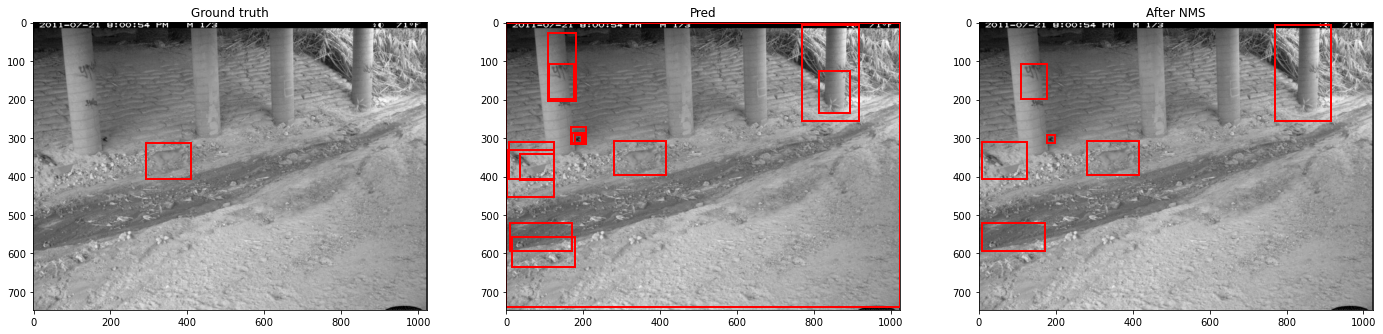

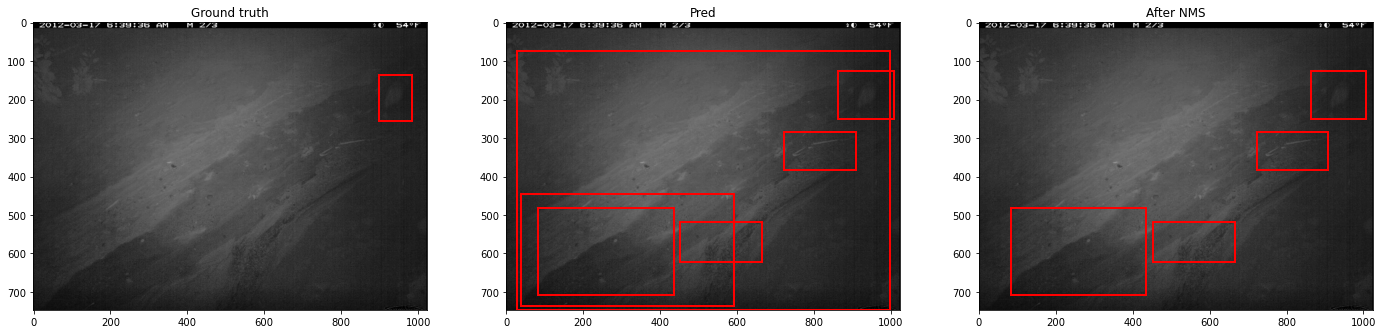

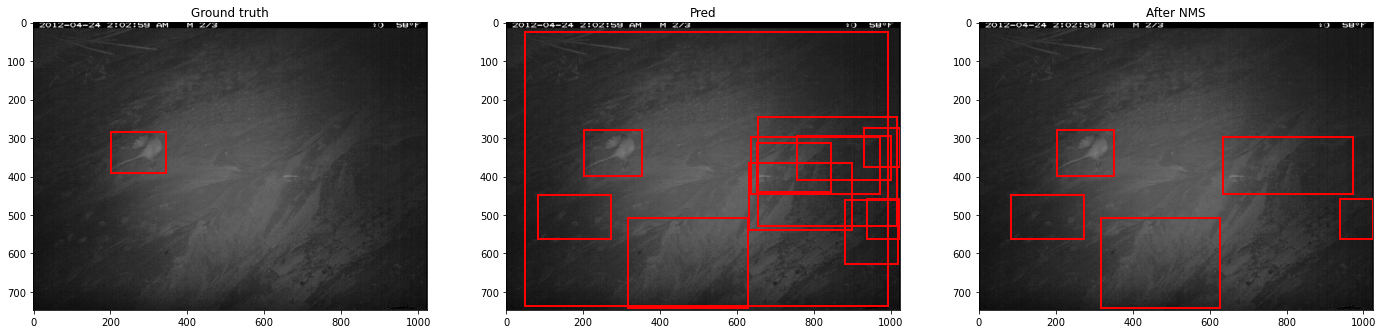

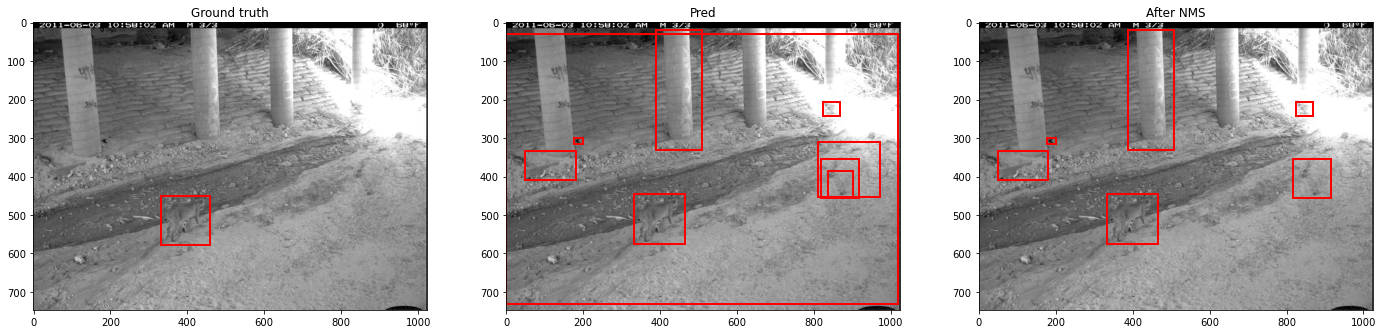

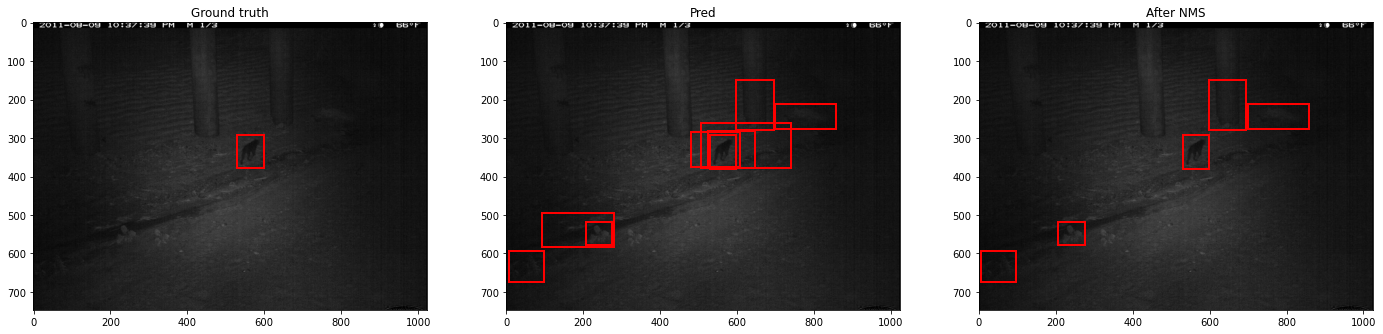

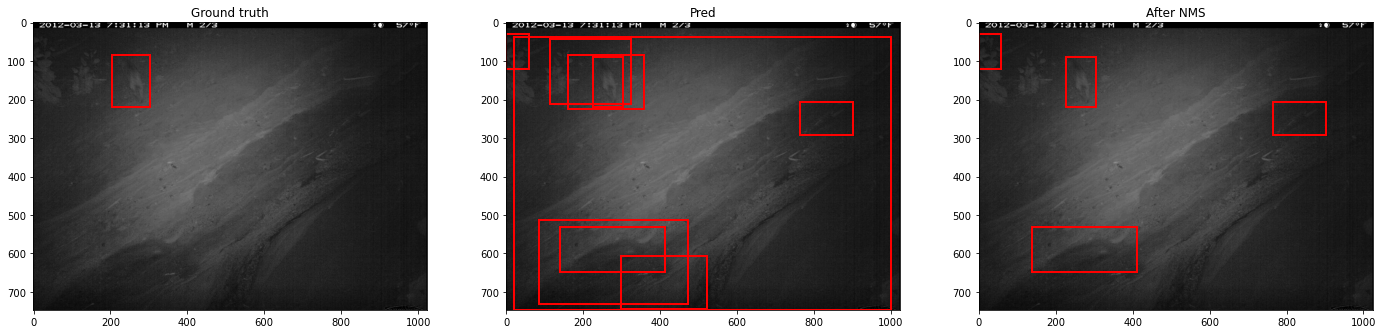

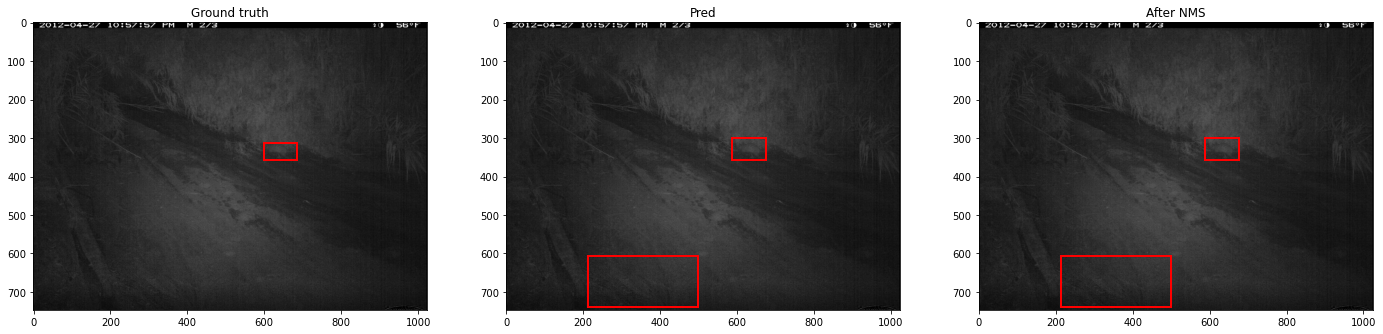

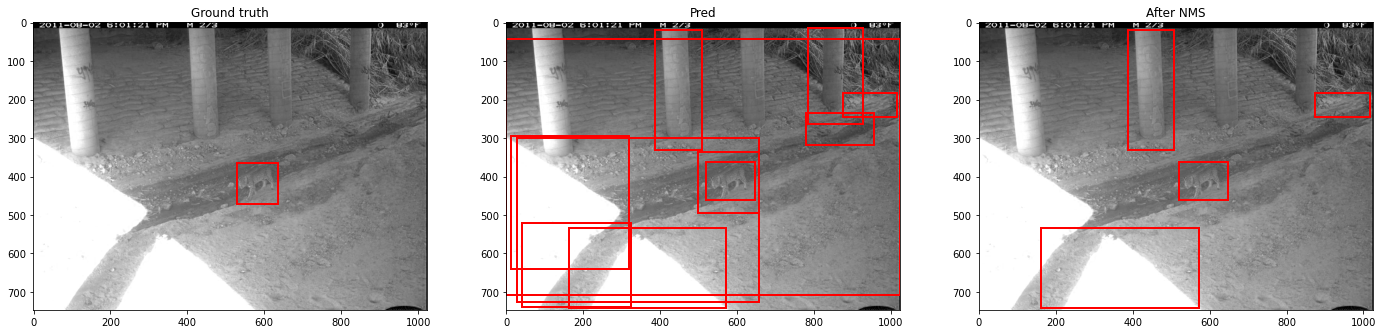

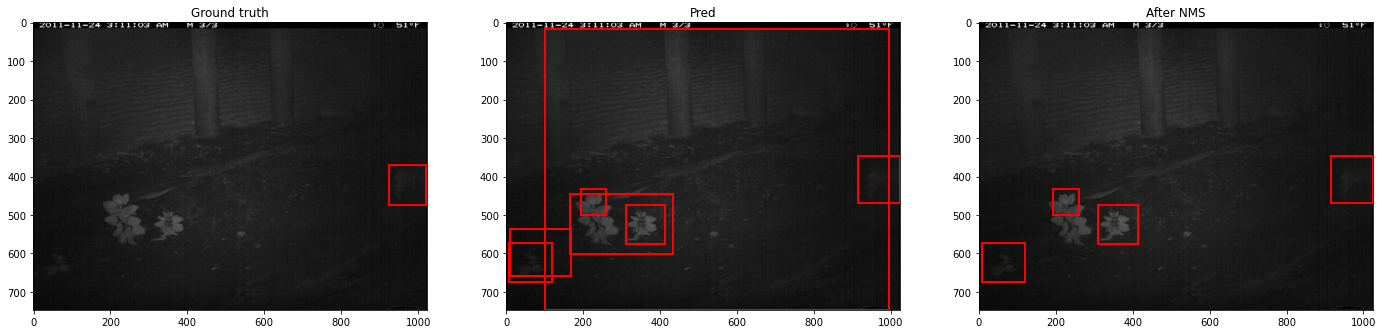

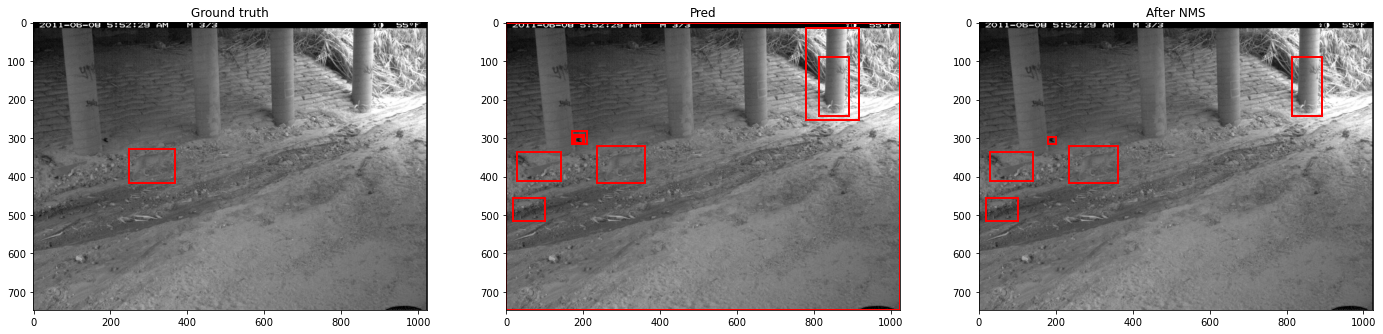

In [38]:
# Prints 10 images with the predictions before and after NMS
# TODO: faire des méthodes pour simplifier le code
for image_i in range(len(image)):
    fig, ax = plt.subplots(1,3,figsize=(24,16))

    ax[0].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    rect = patches.Rectangle((train_labels[image_i]['boxes'][0][0], 
                              train_labels[image_i]['boxes'][0][1]), 
                             train_labels[image_i]['boxes'][0][2]-train_labels[image_i]['boxes'][0][0], 
                             train_labels[image_i]['boxes'][0][3]-train_labels[image_i]['boxes'][0][1], 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
    ax[0].set_title('Ground truth')

    # Predictions
    ax[1].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    for i in range(len(pred[image_i]['boxes'])):
        rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                                  pred[image_i]['boxes'][i][1].cpu()), 
                                 (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                                 (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
    ax[1].set_title('Pred')

    # Predictions after NMS
    iou_threshold = 0.001 # param to tune
    boxes_to_keep = torchvision.ops.nms(pred[image_i]['boxes'], pred[image_i]['scores'], iou_threshold = iou_threshold).cpu()
    ax[2].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    for i in boxes_to_keep:
        rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                                  pred[image_i]['boxes'][i][1].cpu()), 
                                 (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                                 (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[2].add_patch(rect)

    ax[2].set_title('After NMS')

In [ ]:
trans_val_ann['images'][train_labels[3]['image_id']]

In [ ]:
# Print a single image chosen by index from the last batch of 10 predictions
image_i = 3 # from 0 to 9 included

fig, ax = plt.subplots(1,3,figsize=(24,16))

ax[0].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in range(len(train_labels[image_i]['boxes'])):
    rect = patches.Rectangle((train_labels[image_i]['boxes'][i][0], 
                            train_labels[image_i]['boxes'][i][1]), 
                            train_labels[image_i]['boxes'][i][2]-train_labels[image_i]['boxes'][i][0], 
                            train_labels[image_i]['boxes'][i][3]-train_labels[image_i]['boxes'][i][1], 
                            linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
ax[0].set_title('Ground truth')

# Predictions
ax[1].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in range(len(pred[image_i]['boxes'])):
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
ax[1].set_title('Pred')

# Predictions after NMS
iou_threshold = 0.01 # param to tune
boxes_to_keep = torchvision.ops.nms(pred[image_i]['boxes'], pred[image_i]['scores'], iou_threshold = iou_threshold).cpu()
ax[2].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in boxes_to_keep:
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[2].add_patch(rect)

ax[2].set_title('After NMS')

In [ ]:
boxes_to_keep

In [ ]:
pred[image_i]['boxes'][0]

In [ ]:
train_labels[image_i]['boxes']

# Evalutate on COCO detection metrics

### Test on COCO metrics from data loaders
##### 'For evaluation, we consider a detected box to be correct if its IoU ≥ 0.5 with a ground truth box.'

We need to look at the precison score with IoU=0.5, area=all and maxDets=100.
For the recall score, by default it's IoU=0.5:IoU=0.95.

In [29]:
# takes +- 25min to run on cis_test
cis_coco_evaluator = evaluate(cis_test_dataloader, cis_coco)

C:\Users\kevin\miniconda3\envs\animals\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Accumulating evaluation results...
DONE (t=1.90s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.895
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.528
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.555
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.555
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.602
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.602
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [30]:
# takes +- 25min to run on cis_test
trans_coco_evaluator = evaluate(trans_test_dataloader, trans_coco)

KeyboardInterrupt: 

In [ ]:
print('cis test 10 epochs rpn + roi')
print('_'*80)
cis_coco_evaluator.summarize()

In [ ]:
print('trans test 10 epochs rpn + roi')
print('_'*80)
trans_coco_evaluator.summarize()

# Methods

## Method 3 (Subspace alignment based Domain adaptation)

In [ ]:
import torchvision.ops.boxes as bops
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch import nn

Papers 

 1. https://arxiv.org/pdf/1507.05578.pdf

 2.  https://openaccess.thecvf.com/content_iccv_2013/papers/Fernando_Unsupervised_Visual_Domain_2013_ICCV_paper.pdf

**Construct source matrix:** 

We keep output of model.roi_heads.box_head (vector of size 1024) as feature representations of bounding boxes extracted by the RPN (region proposal network). For us to stack a box representation to the source matrix, it has to have a IoU > thres_IoU with the ground truth of the given image. 

In [ ]:
# 20 minutes
thres_IoU = 0.50
count = 0

X_source = torch.tensor([])
bbox_idx = torch.arange(1000)

model.eval()

for images, targets in train_dataloader: 
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    count += 1

    if count%100 == 0:
        print(count)

    with torch.no_grad():
        outputs = []
        hook = model.rpn.register_forward_hook(
        lambda self, input, output: outputs.append(output))

        outputs1 = []
        hook1 = model.roi_heads.box_head.register_forward_hook(
        lambda self, input, output: outputs1.append(output))

        res = model(images)
        hook.remove()
        hook1.remove()

    coords = outputs[0][0][0].cpu() # [1000,4]
    feat = outputs1[0].cpu() # [1000, 1024]

    gt = targets[0]['boxes'].cpu()

    bbox_idx_to_keep = torch.tensor([])
    for i in range(gt.shape[0]):

        IoUs = bops.box_iou(gt[i].reshape(1,4), coords)
        IoUs = IoUs.reshape(1000)
        bbox_idx_to_keep = torch.cat((bbox_idx_to_keep, bbox_idx[IoUs >= thres_IoU]),dim=0)

    X_source = torch.cat((X_source,feat[torch.unique(bbox_idx_to_keep).long()]), dim=0)

In [ ]:
X_source.shape

### Save 1

In [ ]:
torch.save(X_source, 'saved_data/X_source_05_50_rpn_roi_1_100.pt')

In [ ]:
# center data
scaler = StandardScaler()
X_source_scaled = scaler.fit_transform(X_source)

In [ ]:
# Apply PCA, keep only an amount of first components which gives the Projected source matrix

pca = PCA(n_components=100)
pca.fit(X_source_scaled)

X_source_proj = pca.components_
X_source_proj = torch.from_numpy(X_source_proj)


In [ ]:
X_source_proj.shape

In [ ]:
plt.plot(pca.explained_variance_ratio_) 
plt.grid()

### Save 2

In [ ]:
torch.save(X_source_proj, 'saved_data/X_source_proj_05_50_rpn_roi_1_100.pt')

### Target data with batch size 1

In [ ]:
# Target data/distribution = trans test set - Batch Size 1
trans_test_batch1_img,_ = get_img_with_bbox(trans_test_ann_path)
trans_test_batch1_data = CustomImageDataset(trans_test_ann_path, img_folder, trans_test_batch1_img)
trans_test_batch1_dataloader = DataLoader(trans_test_batch1_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

 **Construct target matrix:** 
 
We keep output of model.roi_heads.box_head (vector of size 1024) as feature representations of bounding boxes
 extracted by the RPN (region proposal network). For us to stack a box representation to the source matrix, the predicted bbox associated with the feature has to have a confidence score > thres_conf_score (since we don't use target labels we can't use the IoU here).


In [ ]:
# 30 minutes
thres_conf_score= 0.50 
count=0

X_target=torch.tensor([])

model.eval()

for images, targets in trans_test_batch1_dataloader: # trans location valid AND test ?
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    count+=1

    if count%100==0:
        print(count)

    with torch.no_grad():

        outputs = []
        hook = model.backbone.register_forward_hook(
        lambda self, input, output: outputs.append(output))
        res = model(images)
        hook.remove()

        box_features = model.roi_heads.box_roi_pool(outputs[0], [r['boxes'] for r in res], [i.shape[-2:] for i in images])
        box_features = model.roi_heads.box_head(box_features)

    X_target = torch.cat((X_target,box_features[res[0]['scores']>=thres_conf_score].cpu()), dim=0)


In [ ]:
X_target.shape

In [ ]:
torch.save(X_target, 'saved_data/X_target_05_50_rpn_roi_1_100.pt')

In [ ]:
# center data
scaler = StandardScaler()
X_target_scaled = scaler.fit_transform(X_target)

In [ ]:
# Apply PCA, keep only an amount of first components which gives the Projected source matrix

pca_proj = PCA(n_components=100)
pca_proj.fit(X_target_scaled)

X_target_proj = pca_proj.components_
X_target_proj = torch.from_numpy(X_target_proj)

In [ ]:
plt.plot(pca_proj.explained_variance_ratio_) # we keep 100 dimensions
plt.grid()

In [ ]:
X_target_proj.shape

In [ ]:
torch.save(X_target_proj, 'saved_data/X_target_proj_05_50_rpn_roi_1_100.pt')

### Transformation matrix M

𝑀 is obtained by minimizing the following Bregman matrix divergence (following closed-form solution given in the paper)

In [ ]:
M = torch.matmul(X_source_proj, X_target_proj.T) 

In [ ]:
M.shape

### Project source data into target aligned source subspace

In [ ]:
Xa = torch.matmul(X_source_proj.T,M)

In [ ]:
Xa.shape

In [ ]:
# To project a given feature

# feat(1,1024) x Xa (1024,100)

### Projet target data in target subspace

In [ ]:
# To project a given feature

# feat(1,1024) x X_target_proj.T (1024,100)

### Train adapted model

In [ ]:
import torchvision.ops.boxes as bops
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch import nn

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

In [ ]:
# Load because it takes time to generate the following matrices so they are saved
X_source_proj = torch.load('saved_data/X_source_proj_05_50_rpn_roi_1_512.pt')
X_target_proj = torch.load('saved_data/X_target_proj_05_50_rpn_roi_1_512.pt')

In [ ]:
X_source_proj.device

In [ ]:
M = torch.matmul(X_source_proj, X_target_proj.T) # transformation matrix

Xa = torch.matmul(X_source_proj.T,M) # target aligned source subspace

In [ ]:
M.to(device)

In [ ]:
Xa.to(device)

In [ ]:
# class FastRCNNPredictor_custom(nn.Module):
#     """
#     Standard classification + bounding box regression layers
#     for Fast R-CNN.

#     Args:
#         in_channels (int): number of input channels
#         num_classes (int): number of output classes (including background)
#     """

#     def __init__(self, in_channels, num_classes, m_transfo):
#         super(FastRCNNPredictor_custom, self).__init__()
#         self.cls_score = nn.Sequential(nn.Linear(in_features = 1024, out_features = 100, bias=False), nn.Linear(in_channels, num_classes))
#         self.bbox_pred = nn.Sequential(nn.Linear(in_features = 1024, out_features = 100, bias=False), nn.Linear(in_channels, num_classes * 4))
#         self.cls_score[0].weight= nn.Parameter(m_transfo, requires_grad = False)
#         self.bbox_pred[0].weight= nn.Parameter(m_transfo, requires_grad = False)

#     def forward(self, x):
#         if x.dim() == 4:
#             assert list(x.shape[2:]) == [1, 1]
#         x = x.flatten(start_dim=1)
#         scores = self.cls_score(x)
#         bbox_deltas = self.bbox_pred(x)

#         return scores, bbox_deltas


In [ ]:
class FastRCNNPredictor_custom(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Args:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes, m_transfo):
        super(FastRCNNPredictor_custom, self).__init__()
        self.cls_score = nn.Sequential(nn.Linear(in_features=1024, out_features = in_channels, bias=False),nn.Linear(in_channels, num_classes))
        self.bbox_pred = nn.Sequential(nn.Linear(in_features=1024, out_features = in_channels, bias=False), nn.Linear(in_channels, num_classes * 4))
        self.cls_score[0].weight = nn.Parameter(m_transfo, requires_grad = False)
        self.bbox_pred[0].weight = nn.Parameter(m_transfo, requires_grad = False)

    def forward(self, x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# load fine-tuned weights from the model of the projections
model.load_state_dict(torch.load('saved_models/50_rpn_roi_1_method3.2_512_model.pt'))

for param in model.parameters(): # to freeze all existing weights

    param.requires_grad = False

# vector are of size 100 after the transformation
model.roi_heads.box_predictor = FastRCNNPredictor_custom(M.shape[0], 2, Xa.T.float())
# model.roi_heads.box_predictor = FastRCNNPredictor_custom(in_channels=100, num_classes=2, m_transfo=Xa.T.float()) 

# move model to the right device
model.to(device)

# construct an optimizer
# We will only retrain model.roi_heads.box_predictor (2 last layers)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

In [ ]:
# weights to learn
for i in range(4):
    print(params[i].shape)

In [ ]:
# Nb of weights in the optimizer
for i in range(len(optimizer.param_groups[0]['params'])):
    print(optimizer.param_groups[0]['params'][i].shape)

## Before training

In [ ]:
# PARAMETERS TO TUNE BEFORE TRAINING
num_epochs = 25

# CHECK DEVICE BEFORE TRAINING
torch.cuda.get_device_name(0)

### This next cell starts the training of the model

In [ ]:
# TRAIN
all_train_logs, all_trans_valid_logs, all_cis_valid_logs = train(dataloader=train_dataloader, num_epochs=num_epochs)

In [ ]:
last_train_logs = all_train_logs
last_train_logs = all_train_logs
last_trans_valid_logs = all_trans_valid_logs
last_cis_valid_logs = all_cis_valid_logs

In [ ]:
train_logs = train_logs_to_lst(last_train_logs)
cis_valid_logs = valid_logs_to_lst(last_cis_valid_logs)
trans_valid_logs = valid_logs_to_lst(last_trans_valid_logs)

In [ ]:
# Train loss to print (here we use global_avg but we can use: value, median, avg, max or global_avg)
results_train_loss = []

for i in range(num_epochs):
    results_train_loss.append(train_logs[i]['loss_box_reg']['global_avg'])
    
# Cis valid loss to print
results_cis_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_valid_logs[(167 * i) + j]['loss_box_reg']
    results_cis_valid_loss.append(loss_interm)

# Trans valid loss to print
results_trans_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_valid_logs[(154 * i) + j]['loss_box_reg']
    results_trans_valid_loss.append(loss_interm)

In [ ]:
# Printing the different plots
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(np.arange(1, num_epochs + 1), results_train_loss, label='train')
ax[0].set_title('Train loss per epoch')
ax[0].set_ylabel('loss_box_reg')
ax[0].set_xlabel('epoch')

plt.title('Train loss per epoch')
ax[1].plot(np.arange(1, num_epochs + 1), results_cis_valid_loss, label='cis')
ax[1].plot(np.arange(1, num_epochs + 1), results_trans_valid_loss, label='trans')
ax[1].set_title('Valid loss per epoch')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')
ax[1].legend()

In [ ]:
fig.savefig("figures/" + time.strftime("%Y%m%d_%H%M%S") + "_figure.pdf")

## Evaluate the new model

In [ ]:
# takes +- 15min to run on cis_test
cis_coco_evaluator_method = evaluate(cis_test_dataloader, cis_coco)

In [ ]:
# trans with method 3
model.roi_heads.box_predictor.cls_score[0].weight = nn.Parameter(X_target_proj.float(), requires_grad = False) 
model.roi_heads.box_predictor.bbox_pred[0].weight = nn.Parameter(X_target_proj.float(), requires_grad = False)
model.to(device)

In [ ]:
# takes +- 15min to run on cis_test
trans_coco_evaluator_method = evaluate(trans_test_dataloader, trans_coco)

In [ ]:
print('cis test 50 epochs rpn+roi, method3.2 with 25 epochs & d=512')
print('_'*80)
cis_coco_evaluator_method.summarize()

In [ ]:
print('trans test 50 epochs rpn+roi, method3.2 with 25 epochs & d=512')
print('_'*80)
trans_coco_evaluator_method.summarize()

### Load a model with Method 3.2

In [ ]:
class FastRCNNPredictor_custom(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Args:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes, m_transfo):
        super(FastRCNNPredictor_custom, self).__init__()
        self.cls_score = nn.Sequential(nn.Linear(in_features=1024, out_features = in_channels, bias=False),nn.Linear(in_channels, num_classes))
        self.bbox_pred = nn.Sequential(nn.Linear(in_features=1024, out_features = in_channels, bias=False), nn.Linear(in_channels, num_classes * 4))
        self.cls_score[0].weight = nn.Parameter(m_transfo, requires_grad = False)
        self.bbox_pred[0].weight = nn.Parameter(m_transfo, requires_grad = False)

    def forward(self, x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

for param in model.parameters(): # to freeze all existing weights

    param.requires_grad = False

# vector are of size 100 after the transformation
model.roi_heads.box_predictor = FastRCNNPredictor_custom(M.shape[0], 2, Xa.T.float())
# model.roi_heads.box_predictor = FastRCNNPredictor_custom(in_channels=100, num_classes=2, m_transfo=Xa.T.float()) 

# move model to the right device
model.to(device)

# construct an optimizer
# We will only retrain model.roi_heads.box_predictor (2 last layers)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

In [ ]:
# load fine-tuned weights from the model of the projections
model.load_state_dict(torch.load('saved_models/50_rpn_roi_1_method3.2_512_model.pt'))
optimizer.load_state_dict(torch.load('saved_models/50_rpn_roi_1_method3.2_512_optimizer.pt'))
lr_scheduler.load_state_dict(torch.load('saved_models/50_rpn_roi_1_method3.2_512_scheduler.pt'))